<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/BlackPlague-SIR-BiAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#black plague sir, beta known

import numpy as np
import scipy
import scipy.stats
import scipy.integrate
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit
from matplotlib import cm
import emcee
import pystan
import time
import pytwalk as twalk #upload it 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

sns.set()

In [2]:
pip install emcee

     |████████████████████████████████| 51kB 1.6MB/s 


In [5]:

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

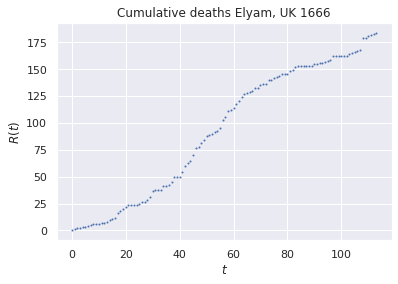

In [6]:

''' Second black plague outbreak in Eyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    
N=261 #Total population   

def SIR( X, t,  alpha, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )



plt.scatter( ts,y, s=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'$R(t)$' )
plt.title('Cumulative deaths Elyam, UK 1666')
plt.savefig('plotcumdeaths.png', dpi=500)
plt.show()



In [1]:
#beta is fixed
pbeta=0.000679 #PTHMC
tbeta=0.000692 #twalk
mcbeta= 0.000685 #emcee



In [2]:



def logprior( Theta):
    alpha=Theta[0]
    I0=Theta[1]
    if( alpha>0 and I0>=1 and I0<=N  ):
         a= -alpha-beta+I0*np.log( 5/N )+(N-I0)*np.log( 1- 5/N   )
         b=scipy.special.loggamma(N+1)- scipy.special.loggamma(I0+1)- scipy.special.loggamma(N-I0+1)
         return a+b
    else:
         return -np.inf
    
    
def logL(Theta):
    alpha=Theta[0]
    I0=Theta[1]
    n=len(y)
    X0=np.array( [N-I0, I0, 0] )
    Xt = odeint( SIR, X0, ts, args=(alpha,beta,I0,))  
    St=Xt[:,0]
    St[St<0]=0
    It= Xt[:,1]
    It[It<0]=0
    Rt=Xt[:,2]
    Rt[Rt>261]=261
    ll=0
    ll=ll+np.log( It[n-2]/N +1e-300 )+(N-1)*np.log( 1- It[n-2]/N    )+N*np.log( 1- It[n-1]/N  )
    ll=ll+ np.sum(y[1:n]* np.log( Rt[1:] /N ))+np.sum( (N-y[1:])  *np.log(   1- Rt[1:]/N +1e-300 ))
    return ll
    

def lpost(Theta): #energy function
    alpha=Theta[0]
    I0=Theta[1]
    if( alpha>0 and I0>=1 and I0<=N  ):
         return -logprior(Theta)-logL(Theta) 
    else:
         return np.inf
  

def bifpoints(f, args, theta, lb, upb, m=100):

    '''
      Function to plot a bivariate posterior
      f is the objective function to be plotted
      args are the arguments of f as a list
      lb: array of lower bounds
      upb:array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])
    temp=np.zeros(2)
    for i in range( m ):
        for j in range( m ):
            temp=np.array( [xx[i][j], yy[i][j]] )
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()

def pSurface(xx,yy, Z):
    fig = plt.figure()
    ax = plt.axes( projection='3d' )
    ax.plot_surface( xx, yy, Z, cmap='Spectral')
    # ax.contour3D(xx, yy, Z, 30, cmap='binary')
    ax.set_xlabel( r'$\theta_1$' )
    ax.set_ylabel( r'$\theta_2$' )
    ax.set_zlabel( r'$Posterior Surface' )
    ax.view_init( 60, 35 )
    fig






In [52]:
beta=0.0009

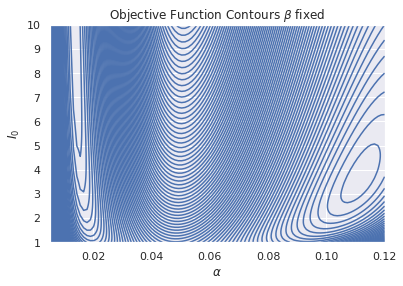

In [49]:

xx,yy,Z= bifpoints(f= lpost,args=1, lb=np.array([ 0.010/2, 1 ])  , upb= np.array([ .120 , 10  ])  , m=100 )

plt.contour( xx, yy, Z, 100, colors='b' )
plt.xlabel( r'$\alpha$')
plt.ylabel( r'$I_0$' )
plt.title( r'Objective Function Contours '+r'$\beta$'+' fixed' )
plt.show()

In [ ]:
#----------------------- t-walk

def p0(): #prior function for the t walk
    a=scipy.stats.uniform.rvs(0, 1 , 1)
    b= scipy.stats.uniform.rvs(0, 1 , 1)
    c=scipy.stats.uniform.rvs(0,10, 1)
   
    return np.array([a[0],b[0],c[0]])


def supp(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>0 and I0<=10 and alpha<1 and beta<1  ):
         return True
    else:
        return False



In [ ]:

T=1000000 #number of iterations
#x0= np.array([1.11528561e-01, 7.42622491e-04, 5.00000000e+00])
#xp0=np.array([1.03351566e-01, 6.55532405e-04, 4.29146012e+00])


Nt=25

alphas=np.zeros( [T+1,Nt] )
betas=np.zeros( [T+1,Nt] )
I0s=np.zeros( [T+1,Nt] )

for i in range(Nt):
  print('======== Iteration : ', i+1,'========')
  x0=p0()
  xp0=p0()
  tchain = twalk.pytwalk( n=3, U=lpost, Supp=supp )
  tchain.Run( T=T , x0= x0 , xp0=xp0)
  alphas[:,i]=tchain.Output[:,0]
  betas[:,i]=tchain.Output[:,1]
  I0s[:,i]=tchain.Output[:,2]








======== Iteration :  1 ========
pytwalk: Running the twalk with 250000 iterations .  Wed, 08 Jul 2020, 03:29:12.
       Finish by Wed, 08 Jul 2020, 03:38.


/content/pytwalk.py:316: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)
/content/pytwalk.py:302: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)
/content/pytwalk.py:358: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) +  (self.nphi-2)*log(beta))


pytwalk:      32768 iterations so far. Finish in approx. 3 min and 22 sec.
pytwalk:     101376 iterations so far. Finish in approx. 2 min and 13 sec.
pytwalk:     237568 iterations so far. Finish in approx. 11 sec.
pytwalk: finished, Wed, 08 Jul 2020, 03:32:54.
======== Iteration :  2 ========
pytwalk: Running the twalk with 250000 iterations .  Wed, 08 Jul 2020, 03:32:54.
       Finish by Wed, 08 Jul 2020, 03:43.
pytwalk:      35840 iterations so far. Finish in approx. 3 min and 3 sec.
pytwalk:     106496 iterations so far. Finish in approx. 2 min and 2 sec.
pytwalk:     248832 iterations so far.  
pytwalk: finished, Wed, 08 Jul 2020, 03:36:27.
======== Iteration :  3 ========
pytwalk: Running the twalk with 250000 iterations .  Wed, 08 Jul 2020, 03:36:27.
       Finish by Wed, 08 Jul 2020, 03:46.


/content/pytwalk.py:378: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) + (W1 - W2))
/content/pytwalk.py:391: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) + (W1 - W2))
/content/pytwalk.py:341: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))


pytwalk:      35840 iterations so far. Finish in approx. 3 min and 3 sec.
pytwalk:     105472 iterations so far. Finish in approx. 2 min and 4 sec.
pytwalk:     246784 iterations so far. Finish in approx. 2 sec.
pytwalk: finished, Wed, 08 Jul 2020, 03:40:01.
======== Iteration :  4 ========
pytwalk: Running the twalk with 250000 iterations .  Wed, 08 Jul 2020, 03:40:01.
       Finish by Wed, 08 Jul 2020, 03:54.
pytwalk:      44032 iterations so far. Finish in approx. 2 min and 23 sec.
pytwalk:     115712 iterations so far. Finish in approx. 1 min and 46 sec.
pytwalk: finished, Wed, 08 Jul 2020, 03:42:49.
======== Iteration :  5 ========
pytwalk: Running the twalk with 250000 iterations .  Wed, 08 Jul 2020, 03:42:49.
       Finish by Wed, 08 Jul 2020, 03:50.
pytwalk:      76800 iterations so far. Finish in approx. 1 min and 8 sec.
pytwalk: finished, Wed, 08 Jul 2020, 03:43:56.
======== Iteration :  6 ========
pytwalk: Running the twalk with 250000 iterations .  Wed, 08 Jul 2020, 03:43:5

In [ ]:

T=1000000 #number of iterations
#x0= np.array([1.11528561e-01, 7.42622491e-04, 5.00000000e+00])
#xp0=np.array([1.03351566e-01, 6.55532405e-04, 4.29146012e+00])


x0=p0()
xp0=p0()
tchain = twalk.pytwalk( n=3, U=lpost, Supp=supp )
tchain.Run( T=T , x0= x0 , xp0=xp0)




pytwalk: Running the twalk with 1000000 iterations .  Wed, 08 Jul 2020, 05:18:52.
       Finish by Wed, 08 Jul 2020, 06:47.


/content/pytwalk.py:302: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)
/content/pytwalk.py:316: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)


pytwalk:      36864 iterations so far. Finish by Wed, 08 Jul 2020, 05:32.
pytwalk:     108544 iterations so far. Finish by Wed, 08 Jul 2020, 05:32.
pytwalk:     254976 iterations so far. Finish by Wed, 08 Jul 2020, 05:32.
pytwalk:     545792 iterations so far. Finish by Wed, 08 Jul 2020, 05:32.
pytwalk: finished, Wed, 08 Jul 2020, 05:32:42.


1

Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[4.26635176e-01 1.07532845e-01 6.00384246e-05 0.00000000e+00]
Global acceptance rate: 0.26301
AutoMaxlag: maxlag= 1677.
Integrated Autocorrelation Time:   437.2, IAT/n:   145.7
AutoMaxlag: maxlag= 1677.


matrix([[437.22865041]])

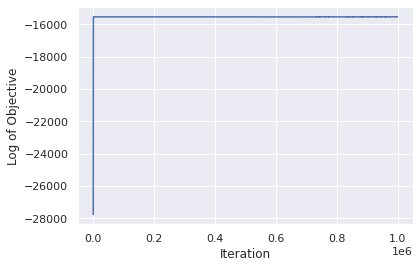

In [ ]:

tchain.Ana()
tchain.IAT()


In [ ]:
tchain.Output[0,:]

array([3.06749186e-02, 5.70604904e-01, 8.23282318e+00, 2.77560946e+04])

In [ ]:
bi=int(0.15*T)
toutput=tchain.Output[bi:, 0:3 ]
print(toutput.shape)


(850001, 3)


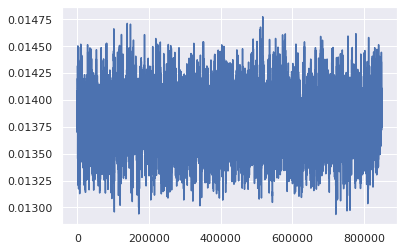

In [ ]:
plt.plot(toutput[:,0])

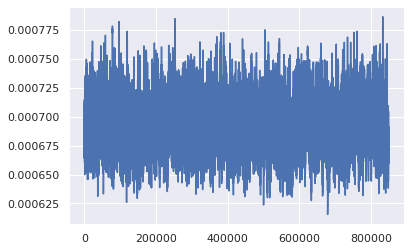

In [ ]:
plt.plot(toutput[:,1])

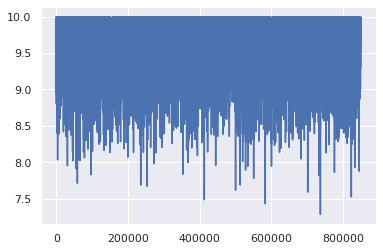

In [ ]:
plt.plot(toutput[:,2])

In [ ]:
alpha=toutput[:,0]
beta=toutput[:,1]
I0=toutput[:,2]

rt={'alpha': alpha, 'beta':beta, 'I0':I0}
rt=pd.DataFrame(rt)

In [ ]:
pd.DataFrame.describe(rt)

,alpha,beta,I0
count,850001.000000,850001.000000,850001.000000
mean,0.013791,0.000693,9.676883
std,0.000224,0.000020,0.313561
min,0.012934,0.000616,7.282331
25%,0.013636,0.000679,9.538859
50%,0.013785,0.000692,9.774293
75%,0.013942,0.000706,9.911594
max,0.014774,0.000786,9.999992


In [ ]:
pd.DataFrame.median(rt)

alpha    0.013785
beta     0.000692
I0       9.774293
dtype: float64

In [ ]:
pd.DataFrame.quantile(rt, (0.025, 0.975))

,alpha,beta,I0
0.025,0.013371,0.000655,8.849957
0.975,0.014237,0.000733,9.992764


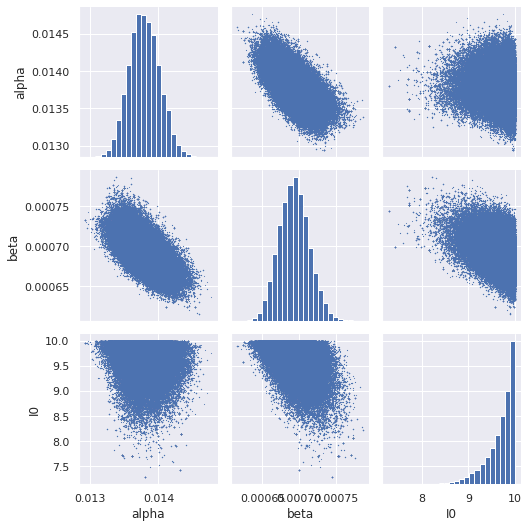

In [ ]:
sns.pairplot(rt, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=25) )
plt.tight_layout()
plt.savefig('twpairplot.png', dpi=500)

In [ ]:

def predobs( alpha, beta, I0s, tup=136  ,sample_size=150 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs
        
        



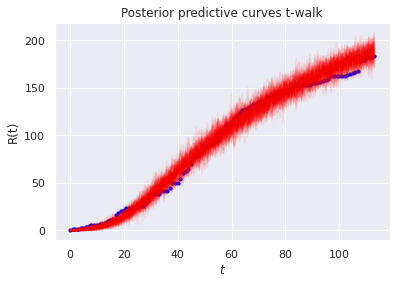

In [ ]:

  
#### Predictive distribution

SSts, IIts, RRts,  obspred=predobs( toutput[:,0] , toutput[:,1] , toutput[:,2]   , tup=114, sample_size=300)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =150, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.07 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves t-walk' )
plt.savefig( 'twalkRtBlackPlague.pdf', dpi=500  )
plt.show()



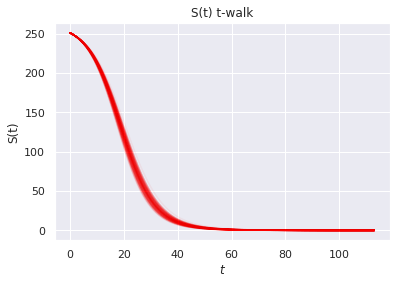

In [ ]:
for i in range( len(obs_samples )  ):
    plt.plot(SSts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'S(t) t-walk' )
plt.savefig( 'twSt.pdf', dpi=500  )
plt.show()



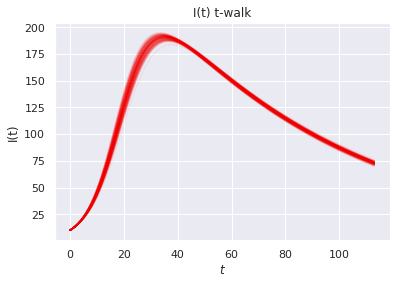

In [ ]:
for i in range( len(obs_samples )  ):
    plt.plot(IIts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'I(t) t-walk' )
plt.savefig( 'twIt.pdf', dpi=500  )
plt.show()


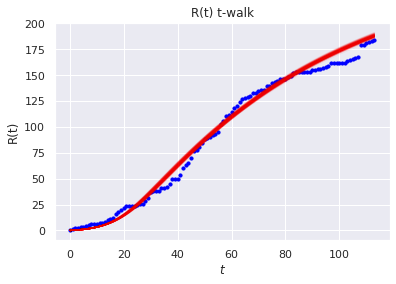

In [ ]:
for i in range( len(obs_samples )  ):
    plt.plot(RRts[i], color='red' , alpha=0.05 )
plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'R(t) t-walk' )
plt.savefig( 'twRt.pdf', dpi=500  )
plt.show()


In [ ]:
# ------------------------------- emcee


def post_emcee(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=10 and alpha<1 and beta<1  ):
         return logprior(Theta)+logL(Theta) 
    else:
         return -np.inf
    

def p0_emcee(nwalkers=1):
    p0=np.zeros([nwalkers,3])
    a=scipy.stats.uniform.rvs(0, 1 , nwalkers)
    b= scipy.stats.uniform.rvs(0, 1 , nwalkers)
    c=scipy.stats.uniform.rvs(0,10, nwalkers)
    p0[:,0]=a
    p0[:,1]=b
    p0[:,2]=c
    return p0


In [ ]:

import os

os.environ["OMP_NUM_THREADS"] = "4"

from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [ ]:
nwalkers = 25
T=250000
bi=int(0.25*T)
p0=p0_emcee(nwalkers)
ndim=p0.shape[1]


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, post_emcee, pool=pool)
    sampler.run_mcmc(p0, T, progress=True)
    

  0%|          | 0/250000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 250000/250000 [1:47:00<00:00, 38.94it/s]


In [ ]:
samples = sampler.get_chain(flat=True)
emcee_chains = sampler.get_chain(discard=bi)



In [ ]:
sampler.get_autocorr_time()

array([ 68.26445601, 139.06692575, 339.95286556])

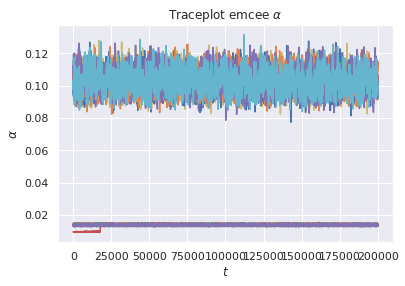

In [ ]:
for i in range(nwalkers):
  plt.plot(emcee_chains[bi:,i,0 ])

plt.xlabel( r'$t$' )
plt.ylabel( r'$\alpha$' )
plt.title( 'Traceplot emcee '+r'$\alpha$' )
plt.savefig( 'mctracealphasir.pdf', dpi=500  )
plt.show()



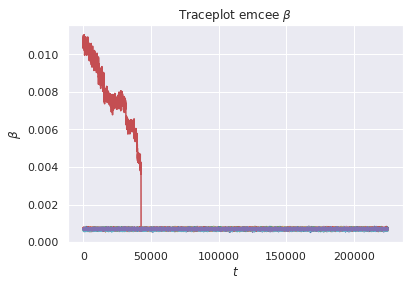

In [ ]:
for i in range(nwalkers):
  plt.plot(emcee_chains[:,i,1 ])

plt.xlabel( r'$t$' )
plt.ylabel( r'$\beta$' )
plt.title( 'Traceplot emcee '+r'$\beta$' )
plt.savefig( 'mctracebetasir.pdf', dpi=500  )
plt.show()



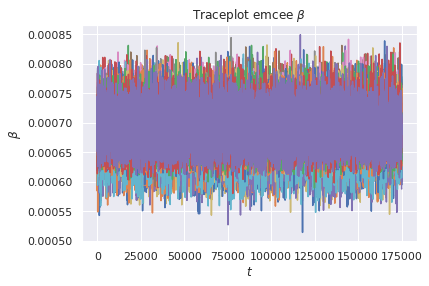

In [ ]:
for i in range(nwalkers):
  plt.plot(emcee_chains[50000:,i,1 ])

plt.xlabel( r'$t$' )
plt.ylabel( r'$\beta$' )
plt.title( 'Traceplot emcee '+r'$\beta$' )
plt.savefig( 'mctracebeta2sir.pdf', dpi=500  )
plt.show()


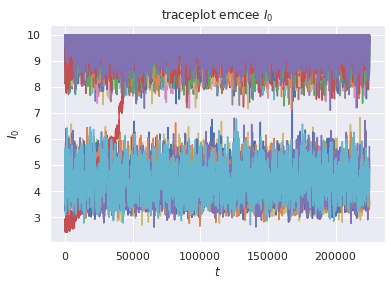

In [ ]:
for i in range(nwalkers):
  plt.plot(emcee_chains[:,i,2 ])


plt.xlabel( r'$t$' )
plt.ylabel( r'$I_0$' )
plt.title( 'traceplot emcee '+r'$I_0$' )
plt.savefig( 'mctraceiosir.pdf', dpi=500  )
plt.show()



In [ ]:
alpha=samples[bi:,0]
beta=samples[bi:,1]
I0=samples[bi:,2]

In [ ]:
d = {'alpha': samples[bi:,0], 'beta': samples[bi:,1], 'I0': samples[bi:,2] }
emceeresults= pd.DataFrame(data=d)


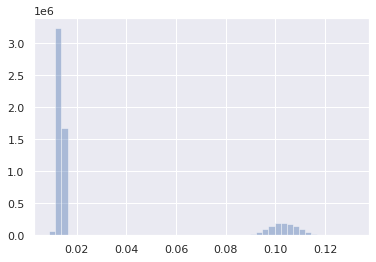

In [ ]:
sns.distplot(  alpha, kde=False    )

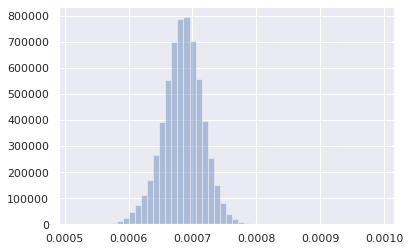

In [ ]:
sns.distplot(  beta[beta<0.001], kde=False    )

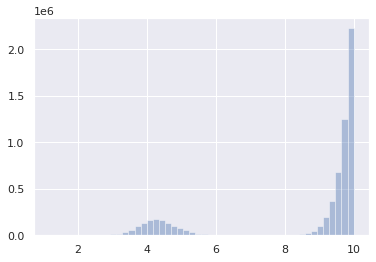

In [ ]:
sns.distplot(  I0, kde=False    )

In [ ]:
talpha=alpha[beta<0.001] 
tbeta=beta[beta<0.001] 
tI0=I0[beta<0.001] 
tmc={ 'alpha':talpha, 'beta':tbeta, 'I0':tI0  }
tmc=pd.DataFrame(tmc)

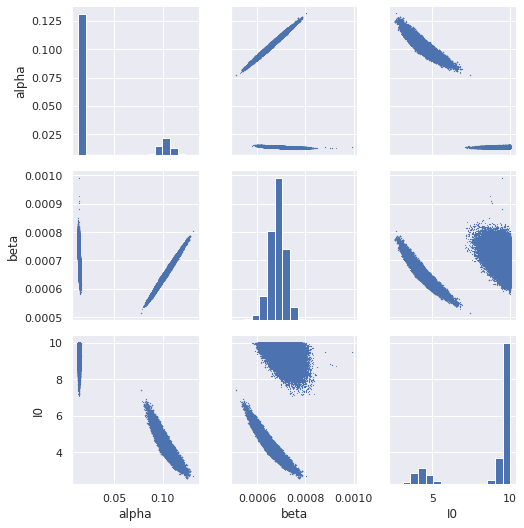

In [ ]:
sns.pairplot(tmc, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=15) )
plt.tight_layout()
plt.savefig('mcpairplot.png', dpi=500)

In [ ]:
### predictive observations

def predobs( alpha, beta, I0s, tup=136  ,sample_size=150 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs

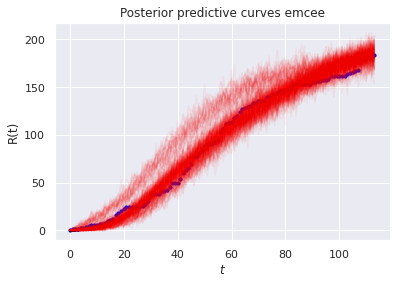

In [ ]:
#### Predictive distribution

SSts, IIts, RRts,  obspred=predobs( talpha , tbeta , tI0   , tup=114, sample_size=500)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =250, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.05 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves emcee' )
plt.savefig( 'mcRtBlackPlague.pdf', dpi=500  )
plt.show()


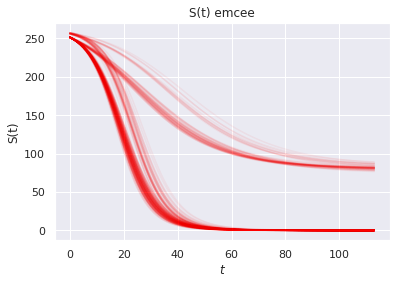

In [ ]:
for i in range( len(obs_samples )  ):
    plt.plot(SSts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'S(t) emcee' )
plt.savefig( 'mcSt.pdf', dpi=500  )
plt.show()

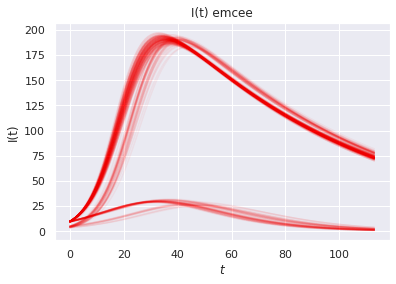

In [ ]:
for i in range( len(obs_samples )  ):
    plt.plot(IIts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'I(t) emcee' )
plt.savefig( 'mcIt.pdf', dpi=500  )
plt.show()

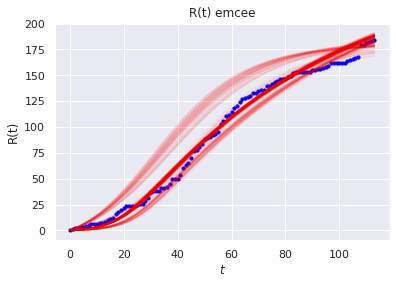

In [ ]:
for i in range( len(obs_samples )  ):
    plt.plot(RRts[i], color='red' , alpha=0.05 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'R(t) emcee' )
plt.savefig( 'mcRt.pdf', dpi=500  )
plt.show()

In [ ]:
pd.DataFrame.describe(tmc)

,alpha,beta,I0
count,6.158319e+06,6.158319e+06,6.158319e+06
mean,3.190169e-02,6.841916e-04,8.629936e+00
std,3.605719e-02,3.113011e-05,2.185736e+00
min,1.246045e-02,5.144909e-04,2.617152e+00
25%,1.365265e-02,6.650588e-04,9.220683e+00
50%,1.389341e-02,6.851069e-04,9.714603e+00
75%,1.427833e-02,7.045972e-04,9.889192e+00
max,1.315374e-01,9.907680e-04,1.000000e+01


In [ ]:
pd.DataFrame.median(tmc)

alpha    0.013893
beta     0.000685
I0       9.714603
dtype: float64

In [ ]:
pd.DataFrame.quantile(tmc, (0.025, 0.975))

,alpha,beta,I0
0.025,0.013262,0.000618,3.751396
0.975,0.110330,0.000743,9.990544


In [ ]:
samples.

(500000, 3)